##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# tf.data: TensorFlow 입력 파이프라인 빌드

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/data" class=""><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/data.ipynb" class=""><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a>   </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

`tf.data` API를 사용하면 간단하고 재사용 가능한 조각으로 복잡한 입력 파이프라인을 빌드할 수 있습니다. 예를 들어, 이미지 모델의 파이프라인은 분산된 파일 시스템의 파일에서 데이터를 집계하고 각 이미지에 임의의 퍼터베이션을 적용하며 무작위로 선택한 이미지를 학습을 위한 batch로 병합할 수 있습니다. 텍스트 모델의 파이프라인에는 원시 텍스트 데이터에서 심볼을 추출하고, 이를 룩업 테이블이 있는 embedding 식별자로 변환하며, 길이가 서로 다른 시퀀스를 batch 처리하는 과정이 포함될 수 있습니다. `tf.data` API를 사용하면 많은 양의 데이터를 처리하고 여러 데이터 형식에서 데이터를 읽으며 복잡한 변환을 수행할 수 있습니다.

`tf.data` API는 일련의 요소를 나타내는 `tf.data.Dataset` 추상화를 도입하며, 여기서 각 요소는 하나 이상의 구성 요소로 이루어집니다. 예를 들어, 이미지 파이프라인에서 요소는 이미지와 해당 label을 나타내는 텐서 구성 요소 쌍이 있는 단일 학습 예일 수 있습니다.

데이터 세트를 생성하는 방법에는 두 가지가 있습니다.

- 데이터 **소스**는 메모리 또는 하나 이상의 파일에 저장된 데이터로부터 `Dataset`를 구성합니다.

- 데이터 **변환**은 하나 이상의 `tf.data.Dataset` 객체로부터 데이터세트를 구성합니다.


In [2]:
import tensorflow as tf

2022-12-14 22:04:10.000151: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:04:10.000238: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:04:10.000248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

## 기본 메커니즘

<a id="basic-mechanics"></a>

입력 파이프라인을 만들려면 데이터 *소스*로 시작해야 합니다. 예를 들어 메모리의 데이터에서 `Dataset`를 구성하려면 `tf.data.Dataset.from_tensors()` 또는 `tf.data.Dataset.from_tensor_slices()`을 사용할 수 있습니다. 또는 입력 데이터가 권장 TFRecord 형식으로 파일에 저장된 경우 `tf.data.TFRecordDataset()`를 사용할 수 있습니다.

`Dataset` 객체가 있으면 `tf.data.Dataset` 객체의 메서드 호출을 연결하여 새로운 `Dataset`로 <em>변환</em>할 수 있습니다. 예를 들어 `Dataset.map`과 같은 요소 별 변환과 `Dataset.batch`와 같은 다중 요소 변환을 적용할 수 있습니다. 전체 변환 목록은 `tf.data.Dataset` 설명서를 참고하십시오.

`Dataset` 객체는 Python 반복 가능합니다. 이를 통해 for 루프를 이용해 해당 요소를 소비할 수 있습니다.

In [4]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [5]:
for elem in dataset:
  print(elem.numpy())

8
3
0
8
2
1


또는 `iter`를 사용하여 명시적으로 Python 반복기(iterator)를 작성하고 `next`를 사용하여 해당 요소를 소비할 수 있습니다.

In [6]:
it = iter(dataset)

print(next(it).numpy())

8


아니면 `reduce` 변환을 사용하여 데이터세트 요소를 소비할 수도 있습니다. 이렇게 하면 모든 요소가 줄어들어 단일 결과가 생성됩니다. 다음 예제는 `reduce` 변환을 사용하여 정수 데이터세트의 합계를 계산하는 방법을 보여줍니다.

In [7]:
print(dataset.reduce(0, lambda state, value: state + value).numpy())

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


22


<!-- TODO(jsimsa): Talk about `tf.function` support. -->

<a id="dataset_structure"></a>

### 데이터세트 구조

데이터세트는 각 요소가 동일한 *구성 요소* (중첩) 구조를 갖는 *요소*의 시퀀스를 생성합니다. 구조의 개별 구성 요소는 `tf.TypeSpec`에 의해 표현되는 어떤 유형일 수도 있으며, 여기에는 `tf.Tensor`, `tf.sparse.SparseTensor`, `tf.RaggedTensor`, `tf.TensorArray` 또는 `tf.data.Dataset`가 포함됩니다.

요소의 (중첩된) 구조를 표현하는 데 사용할 수 있는 Python 구조에는 `tuple`, `dict`, `NamedTuple` 및 `OrderedDict`가 있습니다. 특히 `list`는 데이터세트 요소의 구조를 표현하는 데 유효한 구조가 아닙니다. 이는 초기 `tf.data` 사용자들이 `list` 입력이 자동으로 텐서로 압축(예: `tf.data.Dataset.from_tensors`로 전달될 경우)되고  `list` 출력이 `tuple`로 강제 변환(예: 사용자 정의 함수의 반환 값)되는 부분을 강하게 느꼈기 때문입니다. 결과적으로 `list` 입력을 구조로 처리하려면 이를 `tuple`로 변환해야 하며 `list` 출력이 단일 구성 요소가 되도록 하려면 `tf.stack`을 사용하여 이를 명시적으로 구성해야 합니다.

`Dataset.element_spec` 속성을 사용하면 각 요소의 구성 요소 유형을 검사할 수 있습니다. 이 속성은 단일 구성 요소, 구성 요소의 튜플 또는 구성 요소의 중첩된 튜플일 수 있는 요소의 구조와 일치하는 `tf.TypeSpec` 객체의 *중첩 구조*를 반환합니다. 예를 들면 다음과 같습니다.

In [8]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [9]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [10]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [11]:
# Dataset containing a sparse tensor.
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))

dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [12]:
# Use value_type to see the type of value represented by the element spec
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

`Dataset` 변환은 모든 구조의 데이터세트를 지원합니다. 각 요소에 함수를 적용하는 `Dataset.map` 및 `Dataset.filter` 변환을 사용하는 경우 요소 구조에 따라 함수의 인수가 결정됩니다.

In [13]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

dataset1

<TensorSliceDataset element_spec=TensorSpec(shape=(10,), dtype=tf.int32, name=None)>

In [14]:
for z in dataset1:
  print(z.numpy())

[6 5 2 4 7 4 7 7 4 5]
[1 4 5 5 5 8 2 8 1 8]
[3 3 3 4 8 4 3 8 3 9]
[5 9 1 2 7 6 5 3 6 8]


In [15]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None))>

In [16]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3

<ZipDataset element_spec=(TensorSpec(shape=(10,), dtype=tf.int32, name=None), (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None)))>

In [17]:
for a, (b,c) in dataset3:
  print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))

shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


## 입력 데이터 읽기


### NumPy 배열 소비

자세한 예는 [NumPy 배열 로드](../tutorials/load_data/numpy.ipynb) 튜토리얼을 참고하세요.

모든 입력 데이터가 메모리에 맞는 경우, 여기서 `Dataset`를 생성하는 가장 간단한 방법은 이를 `tf.Tensor` 객체로 변환하고 `Dataset.from_tensor_slices`를 사용하는 것입니다.

In [18]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

 8192/29515 [=======>......................] - ETA: 0s

29515/29515 [==============================] - 0s 0us/step


    8192/26421880 [..............................] - ETA: 0s

 7626752/26421880 [=======>......................] - ETA: 0s

18857984/26421880 [====================>.........] - ETA: 0s

26421880/26421880 [==============================] - 0s 0us/step


5148/5148 [==============================] - 0s 0us/step


   8192/4422102 [..............................] - ETA: 0s

4422102/4422102 [==============================] - 0s 0us/step


In [19]:
images, labels = train
images = images/255

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

참고: 위의 코드 조각은 `features` 및 `labels` 배열을 `tf.constant()` 연산으로 TensorFlow 그래프에 임베딩 처리합니다. 작은 데이터세트일 때는 효과적이지만, 배열의 내용이 여러 번 복사되기 때문에 메모리가 낭비되어 `tf.GraphDef` 프로토콜 버퍼의 2GB 제한에 도달할 수 있습니다.

### Python generator 소비

`tf.data.Dataset`로 쉽게 수집할 수 있는 또 다른 일반적인 데이터 소스는 Python 생성기(generator)입니다.

주의: 이 방법은 편리한 방법이지만 이식성과 확장성이 제한적입니다. 생성기를 생성한 것과 동일한 Python 프로세스에서 실행해야 하며 계속 Python [GIL](https://en.wikipedia.org/wiki/Global_interpreter_lock)의 영향을 받습니다.

In [20]:
def count(stop):
  i = 0
  while i<stop:
    yield i
    i += 1

In [21]:
for n in count(5):
  print(n)

0
1
2
3
4


`Dataset.from_generator` 생성자(constructor)는 Python 생성기를 완벽하게 작동하는 `tf.data.Dataset`로 변환합니다.

이 생성자는 반복기가 아니라 callable을 입력으로 사용합니다. 이를 통해 생성기가 끝에 도달하면 다시 시작할 수 있습니다. callable의 인수로 전달되는 `args` 인수가 선택적으로 사용됩니다.

`tf.data`가 `tf.Graph`를 내부적으로 빌드하고 그래프 엣지에 `tf.dtype`가 필요하기 때문에 `output_types` 인수가 필요합니다.

In [22]:
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )

In [23]:
for count_batch in ds_counter.repeat().batch(10).take(10):
  print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


`output_shapes` 인수는 *필요* 하지 않지만 많은 TensorFlow 연산이 알 수없는 순위의 텐서를 지원하지 않으므로 사용이 권장됩니다. 특정 축의 길이를 알 수 없거나 가변적인 경우 `output_shapes`에서 `None`으로 설정하십시오.

`output_shapes` 및 `output_types`가 다른 데이터세트 메서드와 동일한 중첩 규칙을 따른다는 점도 알고 있어야 합니다.

다음은 두 가지 측면을 모두 보여주는 예제 생성기입니다. 두 배열은 길이가 알려지지 않은 벡터입니다.

In [24]:
def gen_series():
  i = 0
  while True:
    size = np.random.randint(0, 10)
    yield i, np.random.normal(size=(size,))
    i += 1

In [25]:
for i, series in gen_series():
  print(i, ":", str(series))
  if i > 5:
    break

0 : [-0.0993 -0.1054]
1 : [ 1.0119  0.5846 -0.4908]
2 : [-0.2593  0.1929  1.4978 -1.279 ]
3 : [-0.2179 -1.0681 -1.1471 -1.6119]
4 : [ 1.0698  0.7929 -0.462   0.3334  0.3197 -0.1836]
5 : [-0.6459  0.4946  1.1721 -1.1227  0.9971 -0.2345 -1.2515 -0.448  -1.2743]
6 : [-0.6573]


첫 번째 출력은 `int32`이고 두 번째 출력은 `float32`입니다.

첫 번째 항목은 스칼라, 형상 `()`이고 두 번째 항목은 알 수 없는 길이, 형상 `(None,)`의 벡터입니다. 

In [26]:
ds_series = tf.data.Dataset.from_generator(
    gen_series, 
    output_types=(tf.int32, tf.float32), 
    output_shapes=((), (None,)))

ds_series

<FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

이제 이것을 일반 `tf.data.Dataset`처럼 사용할 수 있습니다. 가변 형상이 있는 데이터세트를 배치 처리할 때는 `Dataset.padded_batch`를 사용해야 합니다.

In [27]:
ds_series_batch = ds_series.shuffle(20).padded_batch(10)

ids, sequence_batch = next(iter(ds_series_batch))
print(ids.numpy())
print()
print(sequence_batch.numpy())

[11 19  8 10 20  4  1 18  0 27]

[[ 0.296  -1.6191  0.      0.      0.      0.      0.      0.      0.    ]
 [-0.9099  0.0773  0.1758  1.307   0.5378  1.0263  0.0662 -0.0732  0.    ]
 [-0.3888 -1.8515  0.2199 -0.1618  0.0995 -0.6854  1.4288 -0.3155 -2.4344]
 [-0.5124  1.0701  0.8894  0.0828  0.      0.      0.      0.      0.    ]
 [-1.4451 -1.0792 -2.0013 -0.6358  0.7133  1.4312 -0.3078 -0.2276  0.    ]
 [-0.3596  0.1483 -1.3678  0.3725  0.2422 -0.7689  0.4281  0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [-0.1567 -1.0847  0.0424 -0.0319  0.      0.      0.      0.      0.    ]
 [-0.3635 -1.0749  0.5421 -0.0264 -0.4954  0.1571 -0.5282  0.      0.    ]]


보다 현실적인 예를 보려면 `preprocessing.image.ImageDataGenerator`를 `tf.data.Dataset`로 래핑해 보세요.

먼저, 데이터를 다운로드합니다.

In [28]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

     8192/228813984 [..............................] - ETA: 0s

  9969664/228813984 [>.............................] - ETA: 1s

 24551424/228813984 [==>...........................] - ETA: 0s

 36478976/228813984 [===>..........................] - ETA: 0s

 44515328/228813984 [====>.........................] - ETA: 0s

 51724288/228813984 [=====>........................] - ETA: 0s

 65200128/228813984 [=======>......................] - ETA: 0s

 78831616/228813984 [=========>....................] - ETA: 0s

 92135424/228813984 [===========>..................] - ETA: 0s

105865216/228813984 [============>.................] - ETA: 0s

116621312/228813984 [==============>...............] - ETA: 0s

123510784/228813984 [===============>..............] - ETA: 0s

131457024/228813984 [================>.............] - ETA: 0s

136323072/228813984 [================>.............] - ETA: 0s

142942208/228813984 [=================>............] - ETA: 0s

149118976/228813984 [==================>...........] - ETA: 0s

160137216/228813984 [===================>..........] - ETA: 0s

167141376/228813984 [====================>.........] - ETA: 0s

172105728/228813984 [=====================>........] - ETA: 0s

177160192/228813984 [======================>.......] - ETA: 0s

180953088/228813984 [======================>.......] - ETA: 0s

185565184/228813984 [=======================>......] - ETA: 0s

189227008/228813984 [=======================>......] - ETA: 0s

193880064/228813984 [========================>.....] - ETA: 0s

201555968/228813984 [=========================>....] - ETA: 0s

208617472/228813984 [==========================>...] - ETA: 0s

215941120/228813984 [===========================>..] - ETA: 0s

222937088/228813984 [============================>.] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


`image.ImageDataGenerator`를 만듭니다.

In [29]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [30]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [31]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


In [32]:
ds = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(flowers), 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,256,256,3], [32,5])
)

ds.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [33]:
for images, labels in ds.take(1):
  print('images.shape: ', images.shape)
  print('labels.shape: ', labels.shape)


Found 3670 images belonging to 5 classes.


images.shape:  (32, 256, 256, 3)
labels.shape:  (32, 5)


### TFRecord 데이터 소비하기

엔드 투 엔드 예제는 [TFRecords 로드](../tutorials/load_data/tfrecord.ipynb) 튜토리얼을 참고하세요.

`tf.data` API는 다양한 파일 형식을 지원하므로 메모리에 맞지 않는 큰 데이터세트를 처리할 수 있습니다. 예를 들어, TFRecord 파일 형식은 많은 TensorFlow 애플리케이션이 학습 데이터에 사용하는 간단한 레코드 지향적 바이너리 형식입니다. `tf.data.TFRecordDataset` 클래스를 사용하면 입력 파이프라인의 일부로 하나 이상의 TFRecord 파일 내용을 스트리밍할 수 있습니다.

다음은 프랑스 도로명 표시(FSNS)의 테스트 파일을 사용한 예입니다.

In [34]:
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

   8192/7904079 [..............................] - ETA: 0s

7872512/7904079 [============================>.] - ETA: 0s

7904079/7904079 [==============================] - 0s 0us/step


`TFRecordDataset` 이니셜라이저(initializer)의 `filenames` 인수는 문자열, 문자열 목록 또는 `tf.Tensor` 문자열일 수 있습니다. 따라서 학습 및 검증 목적으로 두 파일 세트를 사용하는 경우, 파일 이름을 입력 인수로 사용하여 데이터세트를 생성하는 팩토리 메서드를 작성할 수 있습니다.


In [35]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

많은 TensorFlow 프로젝트는 TFRecord 파일에서 직렬화된 `tf.train.Example` 레코드를 사용합니다. 검사하기 전에 이를 디코딩해야 합니다.

In [36]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

### 텍스트 데이터 소비하기

엔드 투 엔드 예제는 [텍스트 로드](../tutorials/load_data/text.ipynb) 튜토리얼을 참고하세요.

많은 데이터세트가 하나 이상의 텍스트 파일로 배포됩니다. `tf.data.TextLineDataset`는 하나 이상의 텍스트 파일에서 줄을 추출하는 간편한 방법을 제공합니다. 하나 이상의 파일 이름이 주어지면 `TextLineDataset`는 이러한 파일의 줄당 하나의 문자열 값 요소를 생성합니다.

In [37]:
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url + file_name)
    for file_name in file_names
]

  8192/815980 [..............................] - ETA: 0s

815980/815980 [==============================] - 0s 0us/step


  8192/809730 [..............................] - ETA: 0s

809730/809730 [==============================] - 0s 0us/step


  8192/807992 [..............................] - ETA: 0s

807992/807992 [==============================] - 0s 0us/step


In [38]:
dataset = tf.data.TextLineDataset(file_paths)

첫 번째 파일의 처음 몇 줄은 다음과 같습니다.

In [39]:
for line in dataset.take(5):
  print(line.numpy())

b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b'His wrath pernicious, who ten thousand woes'
b"Caused to Achaia's host, sent many a soul"
b'Illustrious into Ades premature,'
b'And Heroes gave (so stood the will of Jove)'


파일 사이에서 줄을 바꾸려면 `Dataset.interleave`를 사용합니다. 이렇게 하면 파일을 쉽게 섞을 수 있습니다. 각 변환의 첫 번째, 두 번째 및 세 번째 줄은 다음과 같습니다.

In [40]:
files_ds = tf.data.Dataset.from_tensor_slices(file_paths)
lines_ds = files_ds.interleave(tf.data.TextLineDataset, cycle_length=3)

for i, line in enumerate(lines_ds.take(9)):
  if i % 3 == 0:
    print()
  print(line.numpy())


b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b"\xef\xbb\xbfOf Peleus' son, Achilles, sing, O Muse,"
b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought'

b'His wrath pernicious, who ten thousand woes'
b'The vengeance, deep and deadly; whence to Greece'
b'countless ills upon the Achaeans. Many a brave soul did it send'

b"Caused to Achaia's host, sent many a soul"
b'Unnumbered ills arose; which many a soul'
b'hurrying down to Hades, and many a hero did it yield a prey to dogs and'


기본적으로 `TextLineDataset` 은 각 파일의 *모든* 행을 생성하므로 파일이 헤더 행으로 시작하거나 주석이 포함 된 경우 바람직하지 않을 수 있습니다. 이러한 행은 `Dataset.skip()` 또는 `Dataset.filter()` 변환을 사용하여 제거 할 수 있습니다. 여기서 첫 번째 줄을 건너 뛰고 생존자를 찾기 위해 필터링합니다.

In [41]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [42]:
for line in titanic_lines.take(10):
  print(line.numpy())

b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'
b'0,male,22.0,1,0,7.25,Third,unknown,Southampton,n'
b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y'
b'0,male,2.0,3,1,21.075,Third,unknown,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'


In [43]:
def survived(line):
  return tf.not_equal(tf.strings.substr(line, 0, 1), "0")

survivors = titanic_lines.skip(1).filter(survived)

In [44]:
for line in survivors.take(10):
  print(line.numpy())

b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'
b'1,male,28.0,0,0,13.0,Second,unknown,Southampton,y'
b'1,female,28.0,0,0,7.225,Third,unknown,Cherbourg,y'
b'1,male,28.0,0,0,35.5,First,A,Southampton,y'
b'1,female,38.0,1,5,31.3875,Third,unknown,Southampton,n'


### CSV 데이터 소비하기

자세한 예는 [CSV 파일 로드](../tutorials/load_data/csv.ipynb) 및 [Pandas DataFrames 로드](../tutorials/load_data/pandas_dataframe.ipynb) 튜토리얼을 참고하세요.

CSV 파일 형식은 표 형식의 데이터를 일반 텍스트로 저장하는 데 널리 이용되는 형식입니다.

예를 들면 다음과 같습니다.

In [45]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

In [46]:
df = pd.read_csv(titanic_file)
df.head()

survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y

데이터가 메모리에 맞는 경우 동일한 `Dataset.from_tensor_slices` 메서드가 사전에서 작동하여 이 데이터를 쉽게 가져올 수 있습니다.

In [47]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

  'survived'          : 0
  'sex'               : b'male'
  'age'               : 22.0
  'n_siblings_spouses': 1
  'parch'             : 0
  'fare'              : 7.25
  'class'             : b'Third'
  'deck'              : b'unknown'
  'embark_town'       : b'Southampton'
  'alone'             : b'n'


보다 확장성 있는 접근 방식은 필요에 따라 디스크에서 로드하는 것입니다.

`tf.data` 모듈은 [RFC 4180](https://tools.ietf.org/html/rfc4180)을 준수하는 하나 이상의 CSV 파일에서 레코드를 추출하는 메서드를 제공합니다.

`tf.data.experimental.make_csv_dataset` 함수는 csv 파일 세트를 읽기위한 고급 인터페이스입니다. 열 형식 유추와 일괄 처리 및 셔플링과 같은 많은 기능을 지원하며 사용이 간편합니다.

In [48]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived")

In [49]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  print("features:")
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [0 0 1 0]
features:
  'sex'               : [b'male' b'male' b'female' b'male']
  'age'               : [17. 19. 28. 39.]
  'n_siblings_spouses': [1 0 0 0]
  'parch'             : [1 0 0 0]
  'fare'              : [ 7.2292  0.      7.225  24.15  ]
  'class'             : [b'Third' b'Third' b'Third' b'Third']
  'deck'              : [b'unknown' b'unknown' b'unknown' b'unknown']
  'embark_town'       : [b'Cherbourg' b'Southampton' b'Cherbourg' b'Southampton']
  'alone'             : [b'n' b'y' b'y' b'y']


열의 일부만 필요한 경우 `select_columns` 인수를 사용할 수 있습니다.

In [50]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived", select_columns=['class', 'fare', 'survived'])

In [51]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [1 0 1 0]
  'fare'              : [  7.775    7.65   133.65     7.3125]
  'class'             : [b'Third' b'Third' b'First' b'Third']


보다 세밀한 제어를 제공하는 하위 수준의 `experimental.CsvDataset` 클래스도 있습니다. 이 클래스는 열 형식 유추를 지원하지 않으며, 대신 각 열의 유형을 지정해야 합니다.

In [52]:
titanic_types  = [tf.int32, tf.string, tf.float32, tf.int32, tf.int32, tf.float32, tf.string, tf.string, tf.string, tf.string]
dataset = tf.data.experimental.CsvDataset(titanic_file, titanic_types , header=True)

for line in dataset.take(10):
  print([item.numpy() for item in line])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 38.0, 1, 0, 71.2833, b'First', b'C', b'Cherbourg', b'n']
[1, b'female', 26.0, 0, 0, 7.925, b'Third', b'unknown', b'Southampton', b'y']
[1, b'female', 35.0, 1, 0, 53.1, b'First', b'C', b'Southampton', b'n']
[0, b'male', 28.0, 0, 0, 8.4583, b'Third', b'unknown', b'Queenstown', b'y']
[0, b'male', 2.0, 3, 1, 21.075, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 27.0, 0, 2, 11.1333, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 14.0, 1, 0, 30.0708, b'Second', b'unknown', b'Cherbourg', b'n']
[1, b'female', 4.0, 1, 1, 16.7, b'Third', b'G', b'Southampton', b'n']
[0, b'male', 20.0, 0, 0, 8.05, b'Third', b'unknown', b'Southampton', b'y']


일부 열이 비어있는 경우 이 낮은 수준의 인터페이스를 통해 열 유형 대신 기본값을 제공할 수 있습니다.

In [53]:
%%writefile missing.csv
1,2,3,4
,2,3,4
1,,3,4
1,2,,4
1,2,3,
,,,

Writing missing.csv


In [54]:
# Creates a dataset that reads all of the records from two CSV files, each with
# four float columns which may have missing values.

record_defaults = [999,999,999,999]
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults)
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset element_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None)>

In [55]:
for line in dataset:
  print(line.numpy())

[1 2 3 4]
[999   2   3   4]
[  1 999   3   4]
[  1   2 999   4]
[  1   2   3 999]
[999 999 999 999]


기본적으로, `CsvDataset`는 파일에 있는 *모든* 줄의 *모든* 열을 생성하기 때문에, 예를 들어 파일이 무시해야 하는 헤더 줄로 시작하거나 일부 열이 입력에 필요하지 않은 경우 바람직하지 않을 수 있습니다. 이러한 줄과 필드는 `header` 및 `select_cols` 인수로 제거할 수 있습니다.

In [56]:
# Creates a dataset that reads all of the records from two CSV files with
# headers, extracting float data from columns 2 and 4.
record_defaults = [999, 999] # Only provide defaults for the selected columns
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults, select_cols=[1, 3])
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset element_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None)>

In [57]:
for line in dataset:
  print(line.numpy())

[2 4]
[2 4]
[999   4]
[2 4]
[  2 999]
[999 999]


### 파일 세트 소비하기

파일 세트로 분배된 많은 데이터세트가 있으며, 여기서 각 파일은 예입니다.

In [58]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)


참고: 이러한 이미지는 라이센스가 있는 CC-BY입니다. 자세한 내용은 LICENSE.txt를 참조하세요.

루트 디렉토리에는 각 클래스에 대한 디렉토리가 있습니다.

In [59]:
for item in flowers_root.glob("*"):
  print(item.name)

daisy
sunflowers
LICENSE.txt
dandelion
tulips
roses


각 클래스 디렉토리의 파일은 예입니다.

In [60]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

for f in list_ds.take(5):
  print(f.numpy())

b'/home/kbuilder/.keras/datasets/flower_photos/daisy/3720632920_93cf1cc7f3_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/daisy/5673551_01d1ea993e_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/dandelion/4528742654_99d233223b_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/sunflowers/9558630626_52a1b7d702_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/daisy/9299302012_958c70564c_n.jpg'


`tf.io.read_file` 함수를 사용하여 데이터를 읽고 경로에서 레이블을 추출하여 `(image, label)` 쌍을 반환합니다.

In [61]:
def process_path(file_path):
  label = tf.strings.split(file_path, os.sep)[-2]
  return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [62]:
for image_raw, label_text in labeled_ds.take(1):
  print(repr(image_raw.numpy()[:100]))
  print()
  print(label_text.numpy())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05'

b'dandelion'


<!--
TODO(mrry): Add this section.

### Handling text data with unusual sizes
-->

## 데이터세트 요소 배치 처리하기


### 간단한 배치 처리

가장 간단한 형태의 배치 처리는 데이터세트의 `n` 연속 요소를 단일 요소로 스태킹합니다. `Dataset.batch()` 변환은 요소의 각 구성 요소에 적용되는 `tf.stack()` 연산자와 동일한 제약 조건으로 정확하게 이 동작을 수행합니다. 즉, 각 구성 요소 *i*에서 모든 요소는 정확히 같은 형상의 텐서를 가져야 합니다.

In [63]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


`tf.data`가 형상 정보를 전파하려고 할 때 `Dataset.batch`의 기본 설정에서 알 수 없는 배치 크기가 생겨나는데, 마지막 배치가 완전히 채워지지 않았을 수 있기 때문입니다. 형상에서 `None`에 주목하세요.

In [64]:
batched_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

`drop_remainder` 인수를 사용하여 이 마지막 배치를 무시하고 전체 형상 전파를 얻습니다.

In [65]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<BatchDataset element_spec=(TensorSpec(shape=(7,), dtype=tf.int64, name=None), TensorSpec(shape=(7,), dtype=tf.int64, name=None))>

### 패딩이 있는 텐서 배치 처리하기

위의 레시피는 모두 같은 크기의 텐서에 적용됩니다. 그러나 많은 모델(예: 시퀀스 모델)은 다양한 크기(예: 다른 길이의 시퀀스)를 가질 수 있는 입력 데이터로 작동합니다. 이러한 경우에 `Dataset.padded_batch` 변환을 사용하면 패딩 처리될 수 있는 하나 이상의 차원을 지정하여 서로 다른 형상의 텐서를 배치 처리할 수 있습니다.

In [66]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
  print(batch.numpy())
  print()


[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



`Dataset.padded_batch` 변환을 사용하면 각 구성 요소의 각 차원에 대해 서로 다른 패딩을 설정할 수 있으며, 이는 가변 길이(위 예제에서 `None`으로 표시됨) 또는 상수 길이일 수 있습니다. 기본값이 0인 패딩 값을 재정의할 수도 있습니다.

<!--
TODO(mrry): Add this section.

### Dense ragged -> tf.SparseTensor
-->


## 학습 워크플로우


### 여러 epoch 처리하기

`tf.data` API는 동일한 데이터의 여러 epoch를 처리하는 두 가지 주요 방법을 제공합니다.

여러 epoch에서 데이터세트를 반복하는 가장 간단한 방법은 `Dataset.repeat()` 변환을 사용하는 것입니다. 먼저 titanic 데이터의 데이터세트를 만듭니다.

In [67]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [68]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

인수 없이 `Dataset.repeat()` 변환을 적용하면 입력이 무한히 반복됩니다.

`Dataset.repeat` 변환은 한 epoch의 끝과 다음 epoch의 시작을 알리지 않고 인수를 연결합니다. 이 때문에 `Dataset.batch` 후에 적용된 `Dataset.repeat`는 epoch 경계 양쪽에 걸쳐진 배치를 생성합니다.

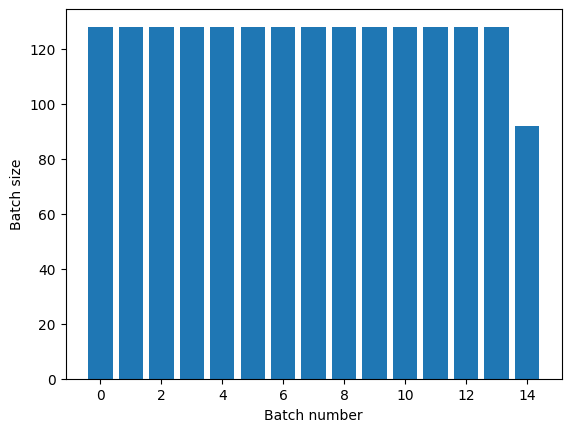

In [69]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

명확한 epoch 분리가 필요한 경우, 반복하기 전에 `Dataset.batch`를 넣으세요.

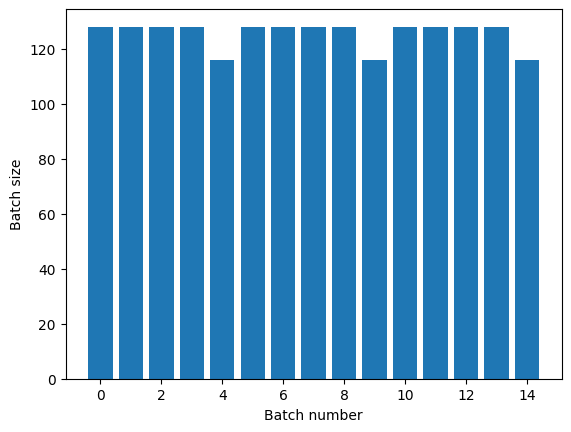

In [70]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

각 Epoch가 끝날 때 사용자 정의 계산(예: 통계 수집)을 수행하려면 각 Epoch에서 데이터세트 반복을 다시 시작하는 것이 가장 간단합니다.

In [71]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


### 입력 데이터의 임의 셔플

`Dataset.shuffle()` 변환은 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 다음 요소를 균일하게 선택합니다.

참고: 큰 buffer_sizes는 더 철저하게 셔플되지만 채우는 데 많은 메모리와 상당한 시간이 소요될 수 있습니다. 이것이 문제가 되는 경우 파일 전체에서 `Dataset.interleave`를 사용하세요.

효과를 확인할 수 있도록 데이터세트에 인덱스를 추가합니다.

In [72]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

`buffer_size`가 100이고 배치 크기가 20이므로 첫 번째 배치에는 120 이상의 인덱스를 가진 요소가 없습니다.

In [73]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[19 80 77 52 22 28 91 70 35 26 44 49 13 58 11 66 40 76 94  7]


`Dataset.batch`의 경우와 마찬가지로 `Dataset.repeat`에 상대적인 순서가 중요합니다.

셔플 버퍼가 비워질 때까지 `Dataset.shuffle`은 epoch의 끝을 알리지 않습니다. 따라서 반복 전에 놓여진 셔플은 다음 epoch로 이동하기 전에 한 epoch의 모든 요소를 표시합니다.

In [74]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[460 615 472 416 161 609 547 589 432 425]
[519 570 525 487 504 587 491 252 528 627]
[394 588 604 515 601 626 584 558]
[63 64 72 75 15 79 57 42 21 19]
[67 43 36  7 73  3 70 46 78 45]


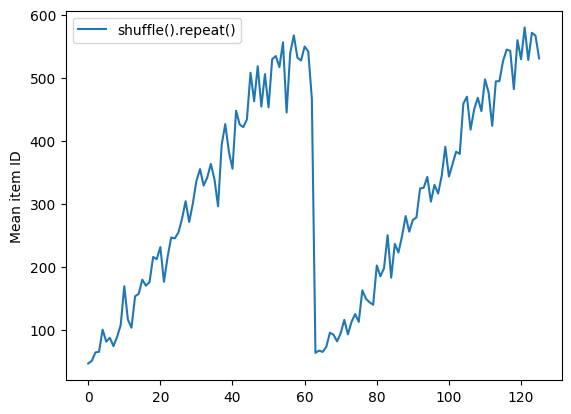

In [75]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

그러나 반복이 셔플 앞에 있으면 epoch 경계가 섞여버립니다.

In [76]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[557 450 343 538 529  16 580   2 611 623]
[459 620   4 567 561 359 536  34 572 518]
[571  40 542  39  38 599 588 574 261 316]
[534 606 622  52 592  26  41 550 464 424]
[ 49 303 564 584 373   8 591  46  20 523]
[582 551 374 457 597  17  44  31  66  27]
[ 54   7 590  42  63 441 514 625 417 595]
[578 531  28  71 462  69  11  70  91  10]
[ 23  76  59 442   6  72   3 617 627 528]
[ 81 543 596  80  19  96  43 116  50  99]
[537  97 104  93   5  14  25 587 430 111]
[ 73 127  13  62  78  82 121 624 105 103]
[ 74  92 483  55  64 143  37 142 106  18]
[484 119  51 145 131 128  30  60  87 109]
[101 122  67 153 114  22  98  77 110   1]


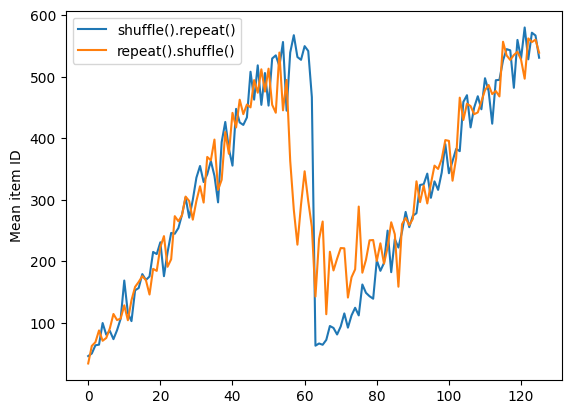

In [77]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

## 데이터 전처리하기

`Dataset.map(f)` 변환은 주어진 함수 `f`를 입력 데이터세트의 각 요소에 적용하여 새 데이터세트를 생성합니다. 여기서 함수형 프로그래밍 언어의 목록(및 기타 구조)에 일반적으로 적용되는 [`map()`](https://en.wikipedia.org/wiki/Map_(higher-order_function)) 함수가 그 기초를 이룹니다. 함수 `f`는 입력에서 단일 요소를 나타내는 `tf.Tensor` 객체를 가져와 새 데이터세트에서 단일 요소를 나타내는 `tf.Tensor` 객체를 반환합니다. 구현시 표준 TensorFlow 작업을 사용하여 한 요소를 다른 요소로 변환합니다.

이 섹션에서는 `Dataset.map()` 사용 방법에 대한 일반적인 예를 다룹니다.


### 이미지 데이터 디코딩 및 크기 조정하기

<!-- TODO(markdaoust): link to image augmentation when it exists -->

실제 이미지 데이터에서 신경망을 학습할 때 크기가 다른 이미지를 일반적 크기로 변환하여 고정 크기로 배치 처리될 수 있도록 해야 하는 경우가 종종 있습니다.

꽃 파일 이름 데이터세트를 다시 빌드합니다.

In [78]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

데이터세트 요소를 조작하는 함수를 작성합니다.

In [79]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

제대로 작동하는지 테스트합니다.

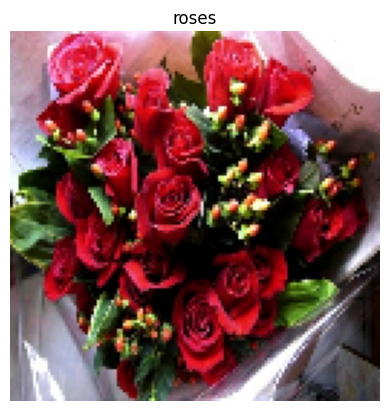

In [80]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

데이터세트에 매핑합니다.

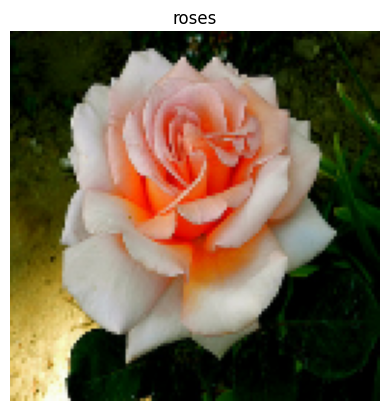

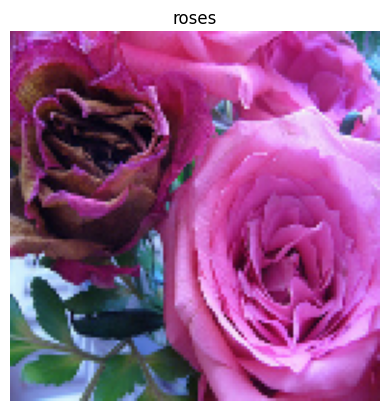

In [81]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

### 임의의 Python 로직 적용하기

성능상의 이유로 가능하면 데이터를 사전 처리하기 위해 TensorFlow 연산을 사용해야 합니다. 그러나 입력 데이터를 구문 분석할 때 외부 Python 라이브러리를 호출하는 것이 유용한 경우가 있습니다. `Dataset.map` 변환에서 `tf.py_function` 연산을 사용할 수 있습니다

예를 들어, 임의 회전을 적용하려는 경우 `tf.image` 모듈에는 `tf.image.rot90`만 있으므로 이미지 확대에는 그다지 유용하지 않습니다.

참고: `tensorflow_addons`에는 `tensorflow_addons.image.rotate`에 TensorFlow와 호환되는 `rotate`가 있습니다.

`tf.py_function`을 데모하려면 `scipy.ndimage.rotate` 함수를 대신 사용해보세요.

In [82]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


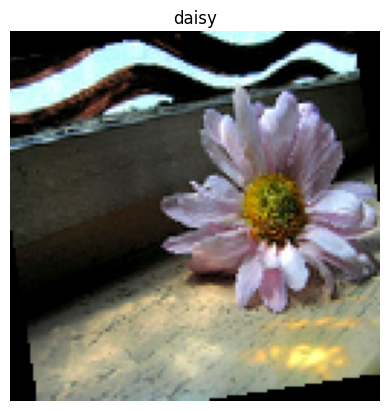

In [83]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

이 함수를 `Dataset.map`과 함께 사용하려면 `Dataset.from_generator`의 경우와 같은 주의 사항이 적용되는데, 함수를 적용할 때 반환 형상과 유형을 설명해야 합니다.

In [84]:
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
  image.set_shape(im_shape)
  return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


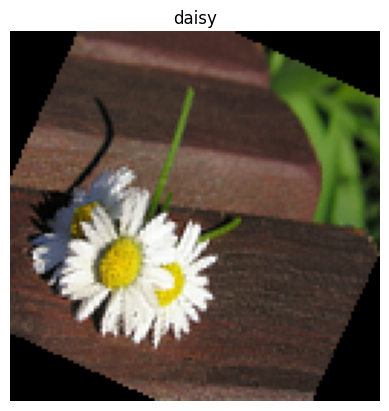

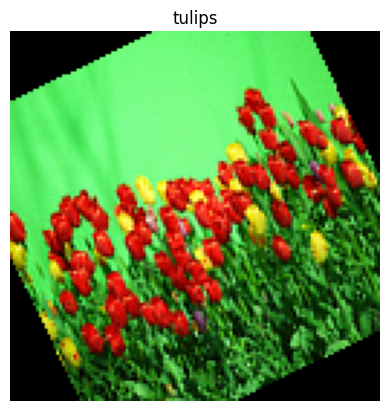

In [85]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
  show(image, label)

### `tf.Example` 프로토콜 버퍼 메시지 구문 분석하기

많은 입력 파이프라인이 TFRecord 형식에서 `tf.train.Example` 프로토콜 버퍼 메시지를 추출합니다. 각 `tf.train.Example` 레코드에는 하나 이상의 "기능"이 포함되며 입력 파이프라인은 일반적으로 이러한 기능을 텐서로 변환합니다.

In [86]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

데이터를 이해하기 위해 `tf.data.Dataset` 외부에서 `tf.train.Example` 프로토콜로 작업할 수 있습니다.

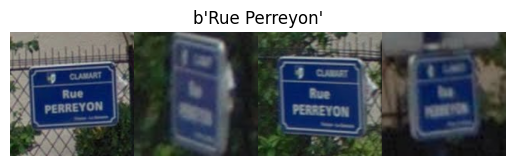

In [87]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0])

In [88]:
raw_example = next(iter(dataset))

In [89]:
def tf_parse(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], {
          'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
          'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
      })
  return example['image/encoded'][0], example['image/text'][0]

In [90]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [91]:
decoded = dataset.map(tf_parse)
decoded

<MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [92]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

<a id="time_series_windowing"></a>

### 시계열 윈도잉

엔드 투 엔드 시계열 예시는 [시계열 예측](../../tutorials/structured_data/time_series.ipynb)을 참고하십시오.

시계열 데이터는 시간 축을 그대로 유지하여 구성되는 경우가 많습니다.

간단한 `Dataset.range`를 사용하여 데모해 보겠습니다.

In [93]:
range_ds = tf.data.Dataset.range(100000)

일반적으로, 이러한 종류의 데이터를 기반으로 하는 모델에는 인접한 시간 조각이 필요할 것입니다.

가장 간단한 방법은 데이터를 배치 처리하는 것입니다.

#### `batch` 사용하기

In [94]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


또는 한 단계 미례로 들어간 밀집된 예측을 하려면 기능과 레이블을 서로 상대적으로 한 단계씩 이동시킬 수 있습니다.

In [95]:
def dense_1_step(batch):
  # Shift features and labels one step relative to each other.
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8]  =>  [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18]  =>  [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28]  =>  [21 22 23 24 25 26 27 28 29]


고정 오프셋 대신 전체 윈도우를 예측하려면 배치를 두 부분으로 분할할 수 있습니다.

In [96]:
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
  return (batch[:-5],   # Inputs: All except the last 5 steps
          batch[-5:])   # Labels: The last 5 steps

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]  =>  [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44]


한 배치의 기능과 다른 배치의 레이블이 약간 겹치게 하려면 `Dataset.zip`을 사용하세요.

In [97]:
feature_length = 10
label_length = 3

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:label_length])

predicted_steps = tf.data.Dataset.zip((features, labels))

for features, label in predicted_steps.take(5):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42]
[40 41 42 43 44 45 46 47 48 49]  =>  [50 51 52]


#### `window` 사용하기

`Dataset.batch`를 사용하는 동안 더 세밀한 제어가 필요한 상황이 있습니다. `Dataset.window` 메서드는 완전한 제어를 제공하지만 약간의 주의가 필요합니다. `Datasets`의 `Dataset`를 반환합니다. 자세한 내용은 [데이터세트 구조](#dataset_structure)를 참조하십시오.

In [98]:
window_size = 5

windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
  print(sub_ds)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


`Dataset.flat_map` 메서드는 데이터세트의 데이터세트를 가져와 단일 데이터세트로 병합할 수 있습니다.

In [99]:
 for x in windows.flat_map(lambda x: x).take(30):
   print(x.numpy(), end=' ')

0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9 

거의 모든 경우에 데이터세트를 먼저 `Dataset.batch`하게 될 것입니다.

In [100]:
def sub_to_batch(sub):
  return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

[0 1 2 3 4]


[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


이제 `shift` 인수에 의해 각 윈도우가 이동하는 정도가 제어되는 것을 알 수 있습니다.

이것을 합치면 다음 함수를 작성할 수 있습니다.

In [101]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows


In [102]:
ds = make_window_dataset(range_ds, window_size=10, shift = 5, stride=3)

for example in ds.take(10):
  print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]


[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


그러면 이전과 같이 레이블을 쉽게 추출할 수 있습니다.

In [103]:
dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
  print(inputs.numpy(), "=>", labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


### 리샘플링

클래스 불균형이 매우 높은 데이터세트로 작업할 때는 데이터세트를 다시 샘플링해야 할 수 있습니다. `tf.data`는 이를 수행하기 위한 두 가지 방법을 제공합니다. 신용카드 사기 데이터세트가 이러한 종류의 문제를 보여주는 좋은 예입니다.

참고: 전체 튜토리얼을 보려면 [불균형 데이터 분류](../tutorials/structured_data/imbalanced_data.ipynb)로 이동하십시오.


In [104]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True)

csv_path = zip_path.replace('.zip', '.csv')

    8192/69155632 [..............................] - ETA: 0s

 4202496/69155632 [>.............................] - ETA: 1s

14704640/69155632 [=====>........................] - ETA: 0s

28303360/69155632 [===========>..................] - ETA: 0s

42049536/69155632 [=================>............] - ETA: 0s

53837824/69155632 [======================>.......] - ETA: 0s

63963136/69155632 [==========================>...] - ETA: 0s

69155632/69155632 [==============================] - 0s 0us/step


In [105]:
creditcard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024, label_name="Class",
    # Set the column types: 30 floats and an int.
    column_defaults=[float()]*30+[int()])

이제 클래스의 분포를 확인해 보면 심하게 치우쳐져 있습니다.

In [106]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)

  return counts

In [107]:
counts = creditcard_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.9952 0.0048]


불균형 데이터세트를 사용하여 학습할 때의 일반적인 접근 방식은 균형을 맞추는 것입니다. `tf.data`에는 이 워크플로우를 가능하게 하는 몇 가지 메서드가 있습니다.

#### 데이터세트 샘플링

데이터세트를 다시 샘플링하는 한 가지 방법은 `sample_from_datasets`를 사용하는 것입니다. 이는 각 클래스에 별도의 `tf.data.Dataset`가 있는 경우에 더 적합합니다.

여기서는 필터를 사용하여 신용카드 사기 데이터로부터 이를 생성합니다.

In [108]:
negative_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==0)
    .repeat())
positive_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==1)
    .repeat())

In [109]:
for features, label in positive_ds.batch(10).take(1):
  print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


`tf.data.Dataset.sample_from_datasets`를 사용하려면 데이터 세트와 각 가중치를 전달하십시오.

In [110]:
balanced_ds = tf.data.Dataset.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(10)

이제 데이터세트는 50/50 확률로 각 클래스의 예를 생성합니다.

In [111]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[1 1 0 0 0 0 0 0 1 0]
[1 1 0 1 1 1 1 0 1 0]
[0 0 1 0 1 1 1 1 1 1]
[1 1 0 0 0 1 1 0 0 1]
[0 0 0 0 0 0 1 1 0 1]
[1 0 1 1 0 0 1 1 0 1]
[0 1 1 1 1 1 0 0 0 0]


[1 1 1 0 1 1 1 0 0 0]
[1 0 1 0 1 0 0 1 1 0]
[0 0 0 0 1 1 0 1 0 0]


#### 거부 리샘플링

위의 `Dataset.sample_from_datasets` 방식에서 한 가지 문제는 클래스별로 개별 `tf.data.Dataset`가 필요하다는 것입니다. `Dataset.filter`를 사용하면 되지만 그 결과로 모든 데이터가 두 번 로드됩니다.

`tf.data.Dataset.rejection_resample` 메서드는 한 번만 로드하여도 데이터세트에 적용하고 재조정할 수 있습니다. 균형을 이루기 위해 요소는 삭제되거나 반복됩니다.

`rejection_resample` 메서드는 `class_func` 인수를 사용합니다. 이 `class_func`는 각 데이터세트 요소에 적용되며 밸런싱을 위해 예제가 속한 클래스를 결정하는 데 사용됩니다.

여기의 목표는 레이블 분포의 균형을 맞추는 것이며 `creditcard_ds`의 요소는 이미 `(features, label)` 쌍입니다. 따라서 `class_func` 해당 레이블을 반환하면됩니다.

In [112]:
def class_func(features, label):
  return label

리샘플링 메서드는 개별 예제를 다루므로 이 메서드를 적용하기 전에 데이터세트를 `unbatch` 처리해야 합니다.

이 메서드는 대상 분포와 선택적으로 초기 분포 추정이 필요합니다.

In [113]:
resample_ds = (
    creditcard_ds
    .unbatch()
    .rejection_resample(class_func, target_dist=[0.5,0.5],
                        initial_dist=fractions)
    .batch(10))

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



`rejection_resample` 메서드는 `class`가 `class_func`의 출력인 `(class, example)` 쌍을 반환합니다. 이 경우 `example`이 이미 `(feature, label)` 쌍이었으므로 `map`을 사용하여 레이블의 추가 복사본을 제거합니다.

In [114]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

이제 데이터세트는 50/50 확률로 각 클래스의 예를 생성합니다.

In [115]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

Proportion of examples rejected by sampler is high: [0.99521482][0.99521482 0.00478515634][0 1]


Proportion of examples rejected by sampler is high: [0.99521482][0.99521482 0.00478515634][0 1]
Proportion of examples rejected by sampler is high: [0.99521482][0.99521482 0.00478515634][0 1]
Proportion of examples rejected by sampler is high: [0.99521482][0.99521482 0.00478515634][0 1]
Proportion of examples rejected by sampler is high: [0.99521482][0.99521482 0.00478515634][0 1]
Proportion of examples rejected by sampler is high: [0.99521482][0.99521482 0.00478515634][0 1]
Proportion of examples rejected by sampler is high: [0.99521482][0.99521482 0.00478515634][0 1]
Proportion of examples rejected by sampler is high: [0.99521482][0.99521482 0.00478515634][0 1]
Proportion of examples rejected by sampler is high: [0.99521482][0.99521482 0.00478515634][0 1]
Proportion of examples rejected by sampler is high: [0.99521482][0.99521482 0.00478515634][0 1]


[0 0 1 0 1 1 0 1 1 0]
[0 0 0 1 1 0 1 1 1 1]
[1 1 1 1 0 1 0 1 1 0]
[1 0 1 0 1 0 0 1 1 0]


[1 1 1 0 1 1 1 0 0 1]
[1 1 1 0 1 1 1 0 1 0]


[1 0 1 1 0 1 1 1 0 1]
[0 0 0 0 0 0 1 0 1 1]
[0 0 0 1 1 0 0 0 0 1]
[0 1 0 0 1 1 1 1 1 1]


## 반복기 검사점 처리

Tensorflow는 [체크 포인트](./checkpoint.ipynb)를 지원하므로 교육 프로세스가 다시 시작될 때 최신 체크 포인트를 복원하여 대부분의 진행 상황을 복구 할 수 있습니다. 모델 변수를 체크 포인트하는 것 외에도 데이터 세트 반복기의 진행 상태를 체크 포인트할 수 있습니다. 이 방법은 큰 데이터세트가 있고 다시 시작할 때마다 데이터세트를 시작하지 않으려는 경우에 유용할 수 있습니다. 그러나 `Dataset.shuffle` 및 `Dataset.prefetch`와 같은 변환은 반복기 내의 버퍼링 요소를 필요로 하므로 반복기 체크 포인트가 클 수 있습니다.

검사점에 반복기를 포함시키려면 반복기를 `tf.train.Checkpoint` 생성자로 전달합니다.

In [116]:
range_ds = tf.data.Dataset.range(20)

iterator = iter(range_ds)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, '/tmp/my_ckpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])

save_path = manager.save()

print([next(iterator).numpy() for _ in range(5)])

ckpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[5, 6, 7, 8, 9]


참고: `tf.py_function`와 같은 외부 상태에 의존하는 반복기는 체크포인트할 수 없습니다. 그렇게 하려고 하면 외부 상태에 대해 불편해하는 예외가 발생합니다.

## tf.data with tf.keras 사용하기

`tf.keras` API는 머신러닝 모델 생성 및 실행의 많은 측면을 단순화합니다. `Model.fit`, `Model.evaluate`, `Model.predict` API는 데이터세트를 입력으로 지원합니다. 다음은 빠른 데이터세트 및 모델 설정입니다.

In [117]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [118]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

`Model.fit` 및 `Model.evaluate`에 대해 필요한 작업은 `(feature, label)` 쌍의 데이터세트를 전달하는 것뿐입니다.

In [119]:
model.fit(fmnist_train_ds, epochs=2)

Epoch 1/2


   1/1875 [..............................] - ETA: 29:23 - loss: 2.5083 - accuracy: 0.1250

  26/1875 [..............................] - ETA: 3s - loss: 1.8047 - accuracy: 0.3522   

  51/1875 [..............................] - ETA: 3s - loss: 1.4935 - accuracy: 0.4865

  76/1875 [>.............................] - ETA: 3s - loss: 1.3425 - accuracy: 0.5419

 101/1875 [>.............................] - ETA: 3s - loss: 1.2358 - accuracy: 0.5792

 127/1875 [=>............................] - ETA: 3s - loss: 1.1570 - accuracy: 0.6075

 153/1875 [=>............................] - ETA: 3s - loss: 1.0998 - accuracy: 0.6252

 179/1875 [=>............................] - ETA: 3s - loss: 1.0542 - accuracy: 0.6414

 205/1875 [==>...........................] - ETA: 3s - loss: 1.0079 - accuracy: 0.6581

 231/1875 [==>...........................] - ETA: 3s - loss: 0.9759 - accuracy: 0.6691

 258/1875 [===>..........................] - ETA: 3s - loss: 0.9522 - accuracy: 0.6782

 284/1875 [===>..........................] - ETA: 3s - loss: 0.9299 - accuracy: 0.6840

 310/1875 [===>..........................] - ETA: 3s - loss: 0.9069 - accuracy: 0.6907

 335/1875 [====>.........................] - ETA: 3s - loss: 0.8873 - accuracy: 0.6970

 361/1875 [====>.........................] - ETA: 2s - loss: 0.8703 - accuracy: 0.7040

 386/1875 [=====>........................] - ETA: 2s - loss: 0.8561 - accuracy: 0.7087

 412/1875 [=====>........................] - ETA: 2s - loss: 0.8439 - accuracy: 0.7127

 438/1875 [======>.......................] - ETA: 2s - loss: 0.8302 - accuracy: 0.7180

 464/1875 [======>.......................] - ETA: 2s - loss: 0.8174 - accuracy: 0.7227

 490/1875 [======>.......................] - ETA: 2s - loss: 0.8063 - accuracy: 0.7254

 516/1875 [=======>......................] - ETA: 2s - loss: 0.7954 - accuracy: 0.7295

 542/1875 [=======>......................] - ETA: 2s - loss: 0.7849 - accuracy: 0.7330

 568/1875 [========>.....................] - ETA: 2s - loss: 0.7753 - accuracy: 0.7366

 594/1875 [========>.....................] - ETA: 2s - loss: 0.7673 - accuracy: 0.7395

 621/1875 [========>.....................] - ETA: 2s - loss: 0.7612 - accuracy: 0.7411

 647/1875 [=========>....................] - ETA: 2s - loss: 0.7540 - accuracy: 0.7432

 673/1875 [=========>....................] - ETA: 2s - loss: 0.7447 - accuracy: 0.7463

 698/1875 [==========>...................] - ETA: 2s - loss: 0.7379 - accuracy: 0.7491

 724/1875 [==========>...................] - ETA: 2s - loss: 0.7328 - accuracy: 0.7506

 749/1875 [==========>...................] - ETA: 2s - loss: 0.7279 - accuracy: 0.7524

 774/1875 [===========>..................] - ETA: 2s - loss: 0.7220 - accuracy: 0.7542

 800/1875 [===========>..................] - ETA: 2s - loss: 0.7177 - accuracy: 0.7555

 826/1875 [============>.................] - ETA: 2s - loss: 0.7124 - accuracy: 0.7574

 852/1875 [============>.................] - ETA: 2s - loss: 0.7069 - accuracy: 0.7597

 878/1875 [=============>................] - ETA: 1s - loss: 0.7033 - accuracy: 0.7607

 904/1875 [=============>................] - ETA: 1s - loss: 0.6989 - accuracy: 0.7621

 930/1875 [=============>................] - ETA: 1s - loss: 0.6939 - accuracy: 0.7639

 956/1875 [==============>...............] - ETA: 1s - loss: 0.6900 - accuracy: 0.7653

 982/1875 [==============>...............] - ETA: 1s - loss: 0.6855 - accuracy: 0.7666

1008/1875 [===============>..............] - ETA: 1s - loss: 0.6832 - accuracy: 0.7678

1034/1875 [===============>..............] - ETA: 1s - loss: 0.6795 - accuracy: 0.7689

1061/1875 [===============>..............] - ETA: 1s - loss: 0.6751 - accuracy: 0.7706

1087/1875 [================>.............] - ETA: 1s - loss: 0.6727 - accuracy: 0.7719

1114/1875 [================>.............] - ETA: 1s - loss: 0.6692 - accuracy: 0.7733

1140/1875 [=================>............] - ETA: 1s - loss: 0.6659 - accuracy: 0.7741

1166/1875 [=================>............] - ETA: 1s - loss: 0.6619 - accuracy: 0.7753

1192/1875 [==================>...........] - ETA: 1s - loss: 0.6585 - accuracy: 0.7767

1217/1875 [==================>...........] - ETA: 1s - loss: 0.6546 - accuracy: 0.7778

1242/1875 [==================>...........] - ETA: 1s - loss: 0.6522 - accuracy: 0.7786

1267/1875 [===================>..........] - ETA: 1s - loss: 0.6497 - accuracy: 0.7793

1292/1875 [===================>..........] - ETA: 1s - loss: 0.6478 - accuracy: 0.7800

1317/1875 [====================>.........] - ETA: 1s - loss: 0.6440 - accuracy: 0.7812

1343/1875 [====================>.........] - ETA: 1s - loss: 0.6422 - accuracy: 0.7822

1368/1875 [====================>.........] - ETA: 1s - loss: 0.6397 - accuracy: 0.7831

1394/1875 [=====================>........] - ETA: 0s - loss: 0.6374 - accuracy: 0.7838

1420/1875 [=====================>........] - ETA: 0s - loss: 0.6347 - accuracy: 0.7847

1446/1875 [======================>.......] - ETA: 0s - loss: 0.6332 - accuracy: 0.7854

1471/1875 [======================>.......] - ETA: 0s - loss: 0.6310 - accuracy: 0.7863

1496/1875 [======================>.......] - ETA: 0s - loss: 0.6284 - accuracy: 0.7872

1522/1875 [=======================>......] - ETA: 0s - loss: 0.6262 - accuracy: 0.7879

1548/1875 [=======================>......] - ETA: 0s - loss: 0.6234 - accuracy: 0.7890

1573/1875 [========================>.....] - ETA: 0s - loss: 0.6218 - accuracy: 0.7893

1598/1875 [========================>.....] - ETA: 0s - loss: 0.6205 - accuracy: 0.7896

1624/1875 [========================>.....] - ETA: 0s - loss: 0.6193 - accuracy: 0.7902

1650/1875 [=========================>....] - ETA: 0s - loss: 0.6176 - accuracy: 0.7910

1676/1875 [=========================>....] - ETA: 0s - loss: 0.6155 - accuracy: 0.7917

1702/1875 [==========================>...] - ETA: 0s - loss: 0.6132 - accuracy: 0.7922

1728/1875 [==========================>...] - ETA: 0s - loss: 0.6110 - accuracy: 0.7929

1754/1875 [===========================>..] - ETA: 0s - loss: 0.6088 - accuracy: 0.7936

1780/1875 [===========================>..] - ETA: 0s - loss: 0.6075 - accuracy: 0.7941

1807/1875 [===========================>..] - ETA: 0s - loss: 0.6062 - accuracy: 0.7944

1833/1875 [============================>.] - ETA: 0s - loss: 0.6042 - accuracy: 0.7950

1859/1875 [============================>.] - ETA: 0s - loss: 0.6019 - accuracy: 0.7959

1875/1875 [==============================] - 5s 2ms/step - loss: 0.6008 - accuracy: 0.7963


Epoch 2/2


   1/1875 [..............................] - ETA: 16s - loss: 0.4650 - accuracy: 0.8750

  27/1875 [..............................] - ETA: 3s - loss: 0.5306 - accuracy: 0.8218 

  53/1875 [..............................] - ETA: 3s - loss: 0.4992 - accuracy: 0.8290

  79/1875 [>.............................] - ETA: 3s - loss: 0.4862 - accuracy: 0.8358

 106/1875 [>.............................] - ETA: 3s - loss: 0.4841 - accuracy: 0.8361

 132/1875 [=>............................] - ETA: 3s - loss: 0.4945 - accuracy: 0.8321

 159/1875 [=>............................] - ETA: 3s - loss: 0.4930 - accuracy: 0.8333

 185/1875 [=>............................] - ETA: 3s - loss: 0.4870 - accuracy: 0.8358

 211/1875 [==>...........................] - ETA: 3s - loss: 0.4912 - accuracy: 0.8349

 238/1875 [==>...........................] - ETA: 3s - loss: 0.4890 - accuracy: 0.8355

 264/1875 [===>..........................] - ETA: 3s - loss: 0.4868 - accuracy: 0.8366

 290/1875 [===>..........................] - ETA: 3s - loss: 0.4826 - accuracy: 0.8375

 316/1875 [====>.........................] - ETA: 3s - loss: 0.4787 - accuracy: 0.8385

 342/1875 [====>.........................] - ETA: 2s - loss: 0.4771 - accuracy: 0.8389

 368/1875 [====>.........................] - ETA: 2s - loss: 0.4724 - accuracy: 0.8415

 393/1875 [=====>........................] - ETA: 2s - loss: 0.4735 - accuracy: 0.8406

 418/1875 [=====>........................] - ETA: 2s - loss: 0.4771 - accuracy: 0.8387

 443/1875 [======>.......................] - ETA: 2s - loss: 0.4767 - accuracy: 0.8387

 469/1875 [======>.......................] - ETA: 2s - loss: 0.4761 - accuracy: 0.8380

 495/1875 [======>.......................] - ETA: 2s - loss: 0.4729 - accuracy: 0.8388

 521/1875 [=======>......................] - ETA: 2s - loss: 0.4742 - accuracy: 0.8383

 548/1875 [=======>......................] - ETA: 2s - loss: 0.4754 - accuracy: 0.8373

 575/1875 [========>.....................] - ETA: 2s - loss: 0.4714 - accuracy: 0.8383

 601/1875 [========>.....................] - ETA: 2s - loss: 0.4727 - accuracy: 0.8374

 628/1875 [=========>....................] - ETA: 2s - loss: 0.4730 - accuracy: 0.8371

 655/1875 [=========>....................] - ETA: 2s - loss: 0.4739 - accuracy: 0.8371

 681/1875 [=========>....................] - ETA: 2s - loss: 0.4715 - accuracy: 0.8383

 707/1875 [==========>...................] - ETA: 2s - loss: 0.4715 - accuracy: 0.8385

 734/1875 [==========>...................] - ETA: 2s - loss: 0.4715 - accuracy: 0.8381

 760/1875 [===========>..................] - ETA: 2s - loss: 0.4703 - accuracy: 0.8382

 787/1875 [===========>..................] - ETA: 2s - loss: 0.4700 - accuracy: 0.8387

 813/1875 [============>.................] - ETA: 2s - loss: 0.4711 - accuracy: 0.8386

 840/1875 [============>.................] - ETA: 2s - loss: 0.4720 - accuracy: 0.8382

 866/1875 [============>.................] - ETA: 1s - loss: 0.4703 - accuracy: 0.8390

 892/1875 [=============>................] - ETA: 1s - loss: 0.4709 - accuracy: 0.8383

 918/1875 [=============>................] - ETA: 1s - loss: 0.4709 - accuracy: 0.8386

 944/1875 [==============>...............] - ETA: 1s - loss: 0.4706 - accuracy: 0.8385

 970/1875 [==============>...............] - ETA: 1s - loss: 0.4678 - accuracy: 0.8393

 996/1875 [==============>...............] - ETA: 1s - loss: 0.4667 - accuracy: 0.8397

1022/1875 [===============>..............] - ETA: 1s - loss: 0.4658 - accuracy: 0.8402

1049/1875 [===============>..............] - ETA: 1s - loss: 0.4654 - accuracy: 0.8401

1075/1875 [================>.............] - ETA: 1s - loss: 0.4666 - accuracy: 0.8401

1101/1875 [================>.............] - ETA: 1s - loss: 0.4668 - accuracy: 0.8400

1127/1875 [=================>............] - ETA: 1s - loss: 0.4664 - accuracy: 0.8401

1152/1875 [=================>............] - ETA: 1s - loss: 0.4653 - accuracy: 0.8407

1177/1875 [=================>............] - ETA: 1s - loss: 0.4653 - accuracy: 0.8407

1203/1875 [==================>...........] - ETA: 1s - loss: 0.4652 - accuracy: 0.8407

1228/1875 [==================>...........] - ETA: 1s - loss: 0.4652 - accuracy: 0.8408

1253/1875 [===================>..........] - ETA: 1s - loss: 0.4665 - accuracy: 0.8405

1278/1875 [===================>..........] - ETA: 1s - loss: 0.4667 - accuracy: 0.8405

1304/1875 [===================>..........] - ETA: 1s - loss: 0.4679 - accuracy: 0.8401

1330/1875 [====================>.........] - ETA: 1s - loss: 0.4680 - accuracy: 0.8401

1355/1875 [====================>.........] - ETA: 1s - loss: 0.4684 - accuracy: 0.8398

1381/1875 [=====================>........] - ETA: 0s - loss: 0.4673 - accuracy: 0.8401

1407/1875 [=====================>........] - ETA: 0s - loss: 0.4677 - accuracy: 0.8399

1433/1875 [=====================>........] - ETA: 0s - loss: 0.4666 - accuracy: 0.8404

1459/1875 [======================>.......] - ETA: 0s - loss: 0.4656 - accuracy: 0.8409

1485/1875 [======================>.......] - ETA: 0s - loss: 0.4643 - accuracy: 0.8415

1510/1875 [=======================>......] - ETA: 0s - loss: 0.4648 - accuracy: 0.8415

1536/1875 [=======================>......] - ETA: 0s - loss: 0.4648 - accuracy: 0.8414

1562/1875 [=======================>......] - ETA: 0s - loss: 0.4656 - accuracy: 0.8409

1588/1875 [========================>.....] - ETA: 0s - loss: 0.4658 - accuracy: 0.8408

1614/1875 [========================>.....] - ETA: 0s - loss: 0.4660 - accuracy: 0.8407

1640/1875 [=========================>....] - ETA: 0s - loss: 0.4659 - accuracy: 0.8408

1666/1875 [=========================>....] - ETA: 0s - loss: 0.4657 - accuracy: 0.8411

1692/1875 [==========================>...] - ETA: 0s - loss: 0.4654 - accuracy: 0.8413

1718/1875 [==========================>...] - ETA: 0s - loss: 0.4650 - accuracy: 0.8413

1744/1875 [==========================>...] - ETA: 0s - loss: 0.4650 - accuracy: 0.8411

1769/1875 [===========================>..] - ETA: 0s - loss: 0.4649 - accuracy: 0.8410

1795/1875 [===========================>..] - ETA: 0s - loss: 0.4642 - accuracy: 0.8412

1820/1875 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.8414

1845/1875 [============================>.] - ETA: 0s - loss: 0.4628 - accuracy: 0.8415

1870/1875 [============================>.] - ETA: 0s - loss: 0.4619 - accuracy: 0.8419

1875/1875 [==============================] - 4s 2ms/step - loss: 0.4620 - accuracy: 0.8418


예를 들어 `Dataset.repeat`를 호출하여 무한한 데이터세트를 전달하는 경우 `steps_per_epoch` 인수도 전달하면 됩니다.

In [120]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Epoch 1/2


 1/20 [>.............................] - ETA: 0s - loss: 0.3654 - accuracy: 0.8750

20/20 [==============================] - 0s 2ms/step - loss: 0.4966 - accuracy: 0.8359


Epoch 2/2


 1/20 [>.............................] - ETA: 0s - loss: 0.6496 - accuracy: 0.8438

20/20 [==============================] - 0s 2ms/step - loss: 0.4751 - accuracy: 0.8344


평가를 위해서는 평가 단계의 수를 전달할 수 있습니다.

In [121]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

   1/1875 [..............................] - ETA: 3:47 - loss: 0.4148 - accuracy: 0.8438

  30/1875 [..............................] - ETA: 3s - loss: 0.4440 - accuracy: 0.8604  

  61/1875 [..............................] - ETA: 3s - loss: 0.4768 - accuracy: 0.8397

  91/1875 [>.............................] - ETA: 3s - loss: 0.4573 - accuracy: 0.8448

 121/1875 [>.............................] - ETA: 2s - loss: 0.4479 - accuracy: 0.8456

 151/1875 [=>............................] - ETA: 2s - loss: 0.4485 - accuracy: 0.8454

 181/1875 [=>............................] - ETA: 2s - loss: 0.4492 - accuracy: 0.8431

 210/1875 [==>...........................] - ETA: 2s - loss: 0.4479 - accuracy: 0.8436

 240/1875 [==>...........................] - ETA: 2s - loss: 0.4481 - accuracy: 0.8445

 270/1875 [===>..........................] - ETA: 2s - loss: 0.4495 - accuracy: 0.8447

 301/1875 [===>..........................] - ETA: 2s - loss: 0.4479 - accuracy: 0.8452

 332/1875 [====>.........................] - ETA: 2s - loss: 0.4432 - accuracy: 0.8460

 363/1875 [====>.........................] - ETA: 2s - loss: 0.4435 - accuracy: 0.8470

 393/1875 [=====>........................] - ETA: 2s - loss: 0.4412 - accuracy: 0.8477

 423/1875 [=====>........................] - ETA: 2s - loss: 0.4428 - accuracy: 0.8471

 453/1875 [======>.......................] - ETA: 2s - loss: 0.4417 - accuracy: 0.8478

 484/1875 [======>.......................] - ETA: 2s - loss: 0.4410 - accuracy: 0.8486

 514/1875 [=======>......................] - ETA: 2s - loss: 0.4444 - accuracy: 0.8473

 543/1875 [=======>......................] - ETA: 2s - loss: 0.4442 - accuracy: 0.8462

 573/1875 [========>.....................] - ETA: 2s - loss: 0.4447 - accuracy: 0.8465

 602/1875 [========>.....................] - ETA: 2s - loss: 0.4465 - accuracy: 0.8458

 631/1875 [=========>....................] - ETA: 2s - loss: 0.4476 - accuracy: 0.8456

 660/1875 [=========>....................] - ETA: 2s - loss: 0.4483 - accuracy: 0.8452

 689/1875 [==========>...................] - ETA: 2s - loss: 0.4490 - accuracy: 0.8446

 718/1875 [==========>...................] - ETA: 1s - loss: 0.4471 - accuracy: 0.8457

 746/1875 [==========>...................] - ETA: 1s - loss: 0.4485 - accuracy: 0.8457

 775/1875 [===========>..................] - ETA: 1s - loss: 0.4484 - accuracy: 0.8459

 805/1875 [===========>..................] - ETA: 1s - loss: 0.4488 - accuracy: 0.8455

 834/1875 [============>.................] - ETA: 1s - loss: 0.4492 - accuracy: 0.8452

 864/1875 [============>.................] - ETA: 1s - loss: 0.4459 - accuracy: 0.8461

 894/1875 [=============>................] - ETA: 1s - loss: 0.4450 - accuracy: 0.8465

 924/1875 [=============>................] - ETA: 1s - loss: 0.4454 - accuracy: 0.8464

 954/1875 [==============>...............] - ETA: 1s - loss: 0.4448 - accuracy: 0.8463

 984/1875 [==============>...............] - ETA: 1s - loss: 0.4443 - accuracy: 0.8465

1014/1875 [===============>..............] - ETA: 1s - loss: 0.4456 - accuracy: 0.8456

1044/1875 [===============>..............] - ETA: 1s - loss: 0.4452 - accuracy: 0.8460

1074/1875 [================>.............] - ETA: 1s - loss: 0.4464 - accuracy: 0.8456

1104/1875 [================>.............] - ETA: 1s - loss: 0.4460 - accuracy: 0.8457

1134/1875 [=================>............] - ETA: 1s - loss: 0.4466 - accuracy: 0.8457

1164/1875 [=================>............] - ETA: 1s - loss: 0.4470 - accuracy: 0.8457

1194/1875 [==================>...........] - ETA: 1s - loss: 0.4462 - accuracy: 0.8459

1224/1875 [==================>...........] - ETA: 1s - loss: 0.4451 - accuracy: 0.8462

1253/1875 [===================>..........] - ETA: 1s - loss: 0.4449 - accuracy: 0.8464

1282/1875 [===================>..........] - ETA: 1s - loss: 0.4446 - accuracy: 0.8467

1310/1875 [===================>..........] - ETA: 0s - loss: 0.4448 - accuracy: 0.8464

1339/1875 [====================>.........] - ETA: 0s - loss: 0.4454 - accuracy: 0.8463

1368/1875 [====================>.........] - ETA: 0s - loss: 0.4454 - accuracy: 0.8461

1396/1875 [=====================>........] - ETA: 0s - loss: 0.4449 - accuracy: 0.8463

1426/1875 [=====================>........] - ETA: 0s - loss: 0.4450 - accuracy: 0.8463

1456/1875 [======================>.......] - ETA: 0s - loss: 0.4437 - accuracy: 0.8468

1485/1875 [======================>.......] - ETA: 0s - loss: 0.4436 - accuracy: 0.8467

1515/1875 [=======================>......] - ETA: 0s - loss: 0.4433 - accuracy: 0.8469

1545/1875 [=======================>......] - ETA: 0s - loss: 0.4426 - accuracy: 0.8472

1575/1875 [========================>.....] - ETA: 0s - loss: 0.4436 - accuracy: 0.8469

1606/1875 [========================>.....] - ETA: 0s - loss: 0.4434 - accuracy: 0.8470

1637/1875 [=========================>....] - ETA: 0s - loss: 0.4437 - accuracy: 0.8469

1667/1875 [=========================>....] - ETA: 0s - loss: 0.4444 - accuracy: 0.8468

1697/1875 [==========================>...] - ETA: 0s - loss: 0.4440 - accuracy: 0.8470

1727/1875 [==========================>...] - ETA: 0s - loss: 0.4441 - accuracy: 0.8470

1755/1875 [===========================>..] - ETA: 0s - loss: 0.4437 - accuracy: 0.8470

1784/1875 [===========================>..] - ETA: 0s - loss: 0.4438 - accuracy: 0.8471

1813/1875 [============================>.] - ETA: 0s - loss: 0.4437 - accuracy: 0.8472

1843/1875 [============================>.] - ETA: 0s - loss: 0.4434 - accuracy: 0.8472

1871/1875 [============================>.] - ETA: 0s - loss: 0.4433 - accuracy: 0.8472

1875/1875 [==============================] - 3s 2ms/step - loss: 0.4436 - accuracy: 0.8472


Loss : 0.4436156153678894
Accuracy : 0.8471500277519226


긴 데이터세트의 경우 평가할 단계 수를 설정합니다.

In [122]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)

 1/10 [==>...........................] - ETA: 2s - loss: 0.4155 - accuracy: 0.8438

10/10 [==============================] - 0s 2ms/step - loss: 0.4113 - accuracy: 0.8594


Loss : 0.4113312363624573
Accuracy : 0.859375


`Model.predict`를 호출할 경우에는 레이블이 필요하지 않습니다.

In [123]:
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

 1/10 [==>...........................] - ETA: 2s

10/10 [==============================] - 0s 1ms/step


(320, 10)


그러나 레이블이 포함된 데이터세트를 전달하면 레이블이 무시됩니다.

In [124]:
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

 1/10 [==>...........................] - ETA: 0s

10/10 [==============================] - 0s 1ms/step


(320, 10)
